# Energy Storage System Modeling Using Time Series Clustering for Long-term Planning.

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
data = pd.read_csv("E_consumption_productioction.csv")
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)

In [6]:
data

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
DateTime,,,,,,,,,
2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30
...,...,...,...,...,...,...,...,...,...
2024-03-31 19:00:00,5618,5902,1398,505,2294,1012,620,6,65
2024-03-31 20:00:00,6107,6205,1395,671,2389,1037,645,0,66
2024-03-31 21:00:00,5991,5855,1395,868,2201,705,621,0,66


In [8]:
null_summary = data.isnull().sum()
print("Null values in each column:\n", null_summary)

Null values in each column:
 Consumption      0
Production       0
Nuclear          0
Wind             0
Hydroelectric    0
Oil and Gas      0
Coal             0
Solar            0
Biomass          0
dtype: int64


In [10]:
# Filter for 2022
data_2022 = data[data.index.year == 2022]

# Identify duplicates
duplicates = data_2022.index[data_2022.index.duplicated()]
print("Duplicate timestamps:", duplicates)

# Remove duplicates (keep the first occurrence)
data_2022 = data_2022[~data_2022.index.duplicated(keep='first')]

# Create the complete hourly DatetimeIndex for 2022
full_index_2022 = pd.date_range(start="2022-01-01 00:00:00", end="2022-12-31 23:00:00", freq='H')

# Reindex and forward fill missing values
data_2022 = data_2022.reindex(full_index_2022).ffill()

# Add frequency information
data_2022.index.freq = 'h'

# Step 7: Verify the result
print(data_2022)
print("Index frequency:", data_2022.index.freq)

Duplicate timestamps: DatetimeIndex(['2022-10-30 03:00:00', '2022-10-30 03:00:00'], dtype='datetime64[ns]', name='DateTime', freq=None)
                     Consumption  Production  Nuclear    Wind  Hydroelectric  \
2022-01-01 00:00:00       6120.0      6126.0   1417.0  1136.0         1405.0   
2022-01-01 01:00:00       5923.0      6276.0   1421.0  1124.0         1482.0   
2022-01-01 02:00:00       5630.0      6298.0   1420.0   921.0         1618.0   
2022-01-01 03:00:00       5408.0      6199.0   1422.0   666.0         1742.0   
2022-01-01 04:00:00       5296.0      6215.0   1422.0   877.0         1633.0   
...                          ...         ...      ...     ...            ...   
2022-12-31 19:00:00       6557.0      6782.0   1405.0   715.0         2211.0   
2022-12-31 20:00:00       6335.0      6779.0   1406.0   745.0         2171.0   
2022-12-31 21:00:00       5728.0      6430.0   1410.0   841.0         1804.0   
2022-12-31 22:00:00       5564.0      6259.0   1409.0   911.0   

C:\Users\mdabu\AppData\Local\Temp\ipykernel_3932\2133776753.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index_2022 = pd.date_range(start="2022-01-01 00:00:00", end="2022-12-31 23:00:00", freq='H')


In [12]:
data_2022

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
2022-01-01 00:00:00,6120.0,6126.0,1417.0,1136.0,1405.0,1091.0,1022.0,0.0,56.0
2022-01-01 01:00:00,5923.0,6276.0,1421.0,1124.0,1482.0,1157.0,1036.0,0.0,56.0
2022-01-01 02:00:00,5630.0,6298.0,1420.0,921.0,1618.0,1231.0,1050.0,0.0,56.0
2022-01-01 03:00:00,5408.0,6199.0,1422.0,666.0,1742.0,1255.0,1058.0,0.0,56.0
2022-01-01 04:00:00,5296.0,6215.0,1422.0,877.0,1633.0,1206.0,1019.0,0.0,58.0
...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,6557.0,6782.0,1405.0,715.0,2211.0,1528.0,888.0,0.0,33.0
2022-12-31 20:00:00,6335.0,6779.0,1406.0,745.0,2171.0,1535.0,888.0,0.0,34.0
2022-12-31 21:00:00,5728.0,6430.0,1410.0,841.0,1804.0,1505.0,835.0,0.0,34.0
2022-12-31 22:00:00,5564.0,6259.0,1409.0,911.0,1541.0,1510.0,853.0,0.0,32.0


In [14]:
null_summary1 = data_2022.isnull().sum()
print("Null values in each column:\n", null_summary)

Null values in each column:
 Consumption      0
Production       0
Nuclear          0
Wind             0
Hydroelectric    0
Oil and Gas      0
Coal             0
Solar            0
Biomass          0
dtype: int64


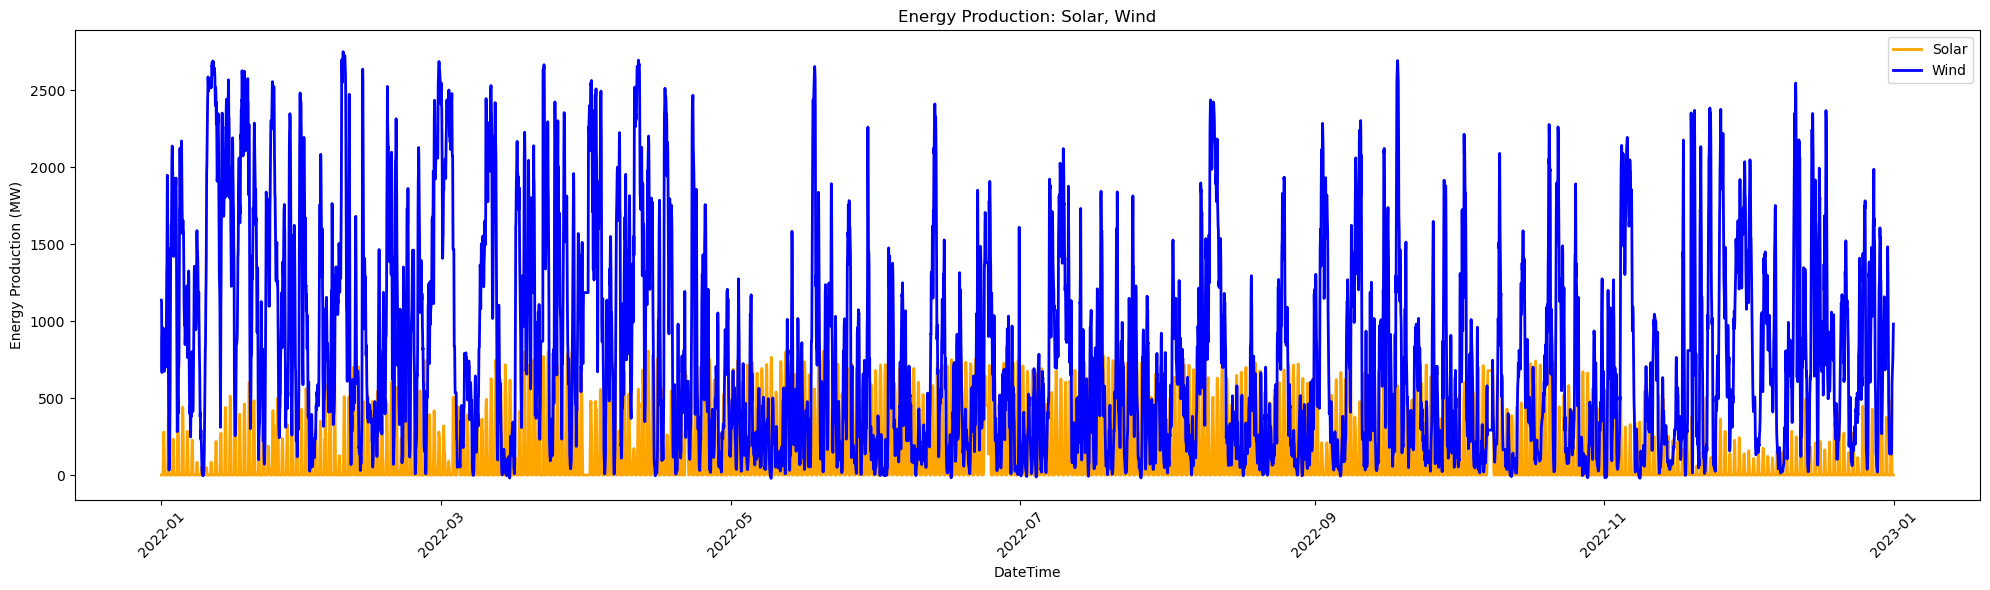

In [16]:
# Find intermittency of solar and wind
plt.figure(figsize=(20, 6))

# Plot for Solar, Wind
plt.plot(data_2022.index, data_2022['Solar'], label='Solar', color='orange', linewidth=2)
plt.plot(data_2022.index, data_2022['Wind'], label='Wind', color='blue', linewidth=2)

# Add labels and title
plt.xlabel('DateTime')
plt.ylabel('Energy Production (MW)')
plt.title('Energy Production: Solar, Wind')
plt.legend(loc='upper right')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
plt.tight_layout()
# Save the plot
plt.savefig('example_plot1.png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()

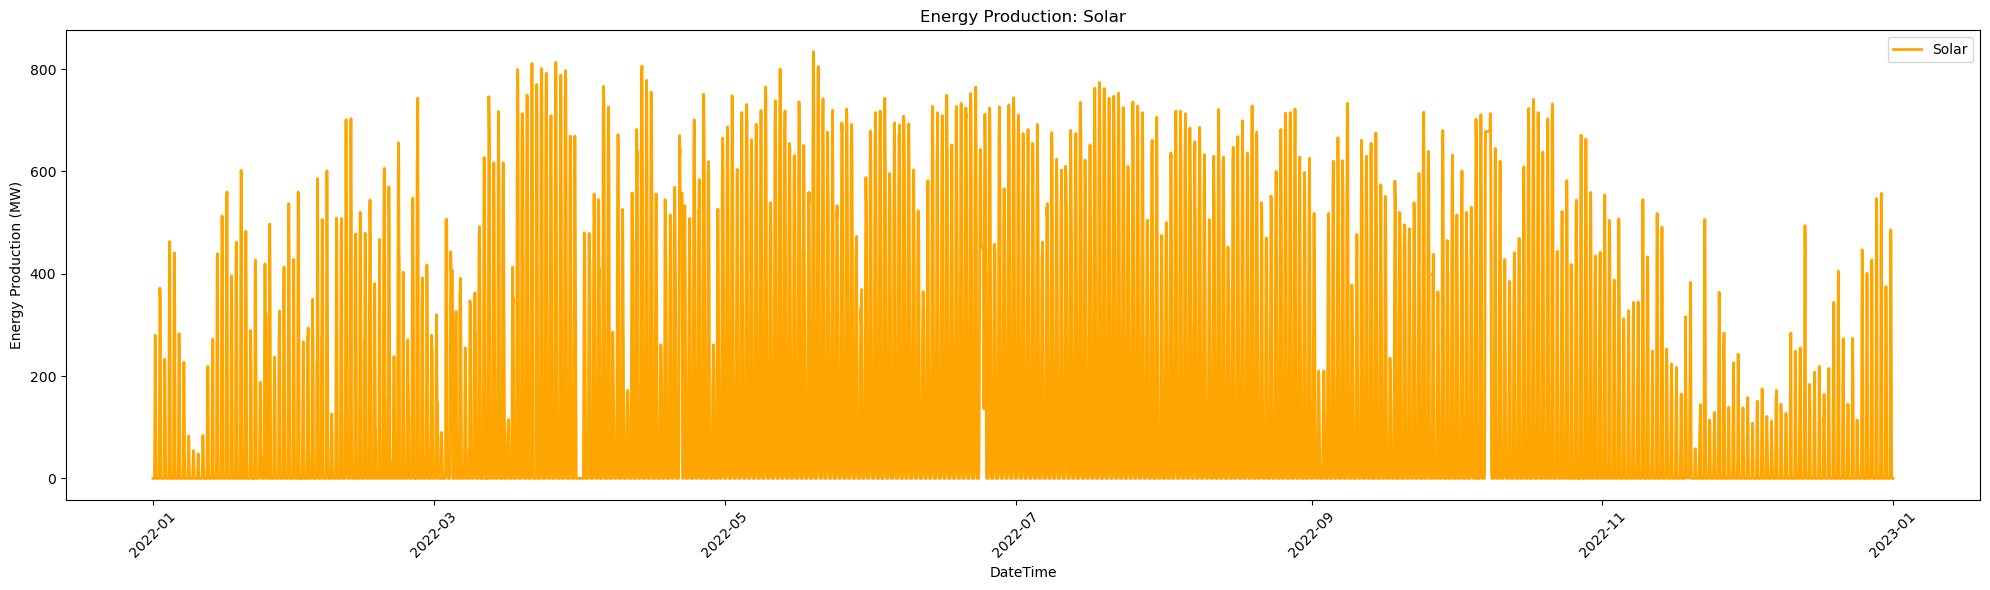

In [17]:
# Find intermittency of solar 
plt.figure(figsize=(20, 6))

# Plot for Solar
plt.plot(data_2022.index, data_2022['Solar'], label='Solar', color='orange', linewidth=2)

# Add labels and title
plt.xlabel('DateTime')
plt.ylabel('Energy Production (MW)')
plt.title('Energy Production: Solar')
plt.legend(loc='upper right')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
plt.tight_layout()
# Save the plot
plt.savefig('example_plot2.png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()


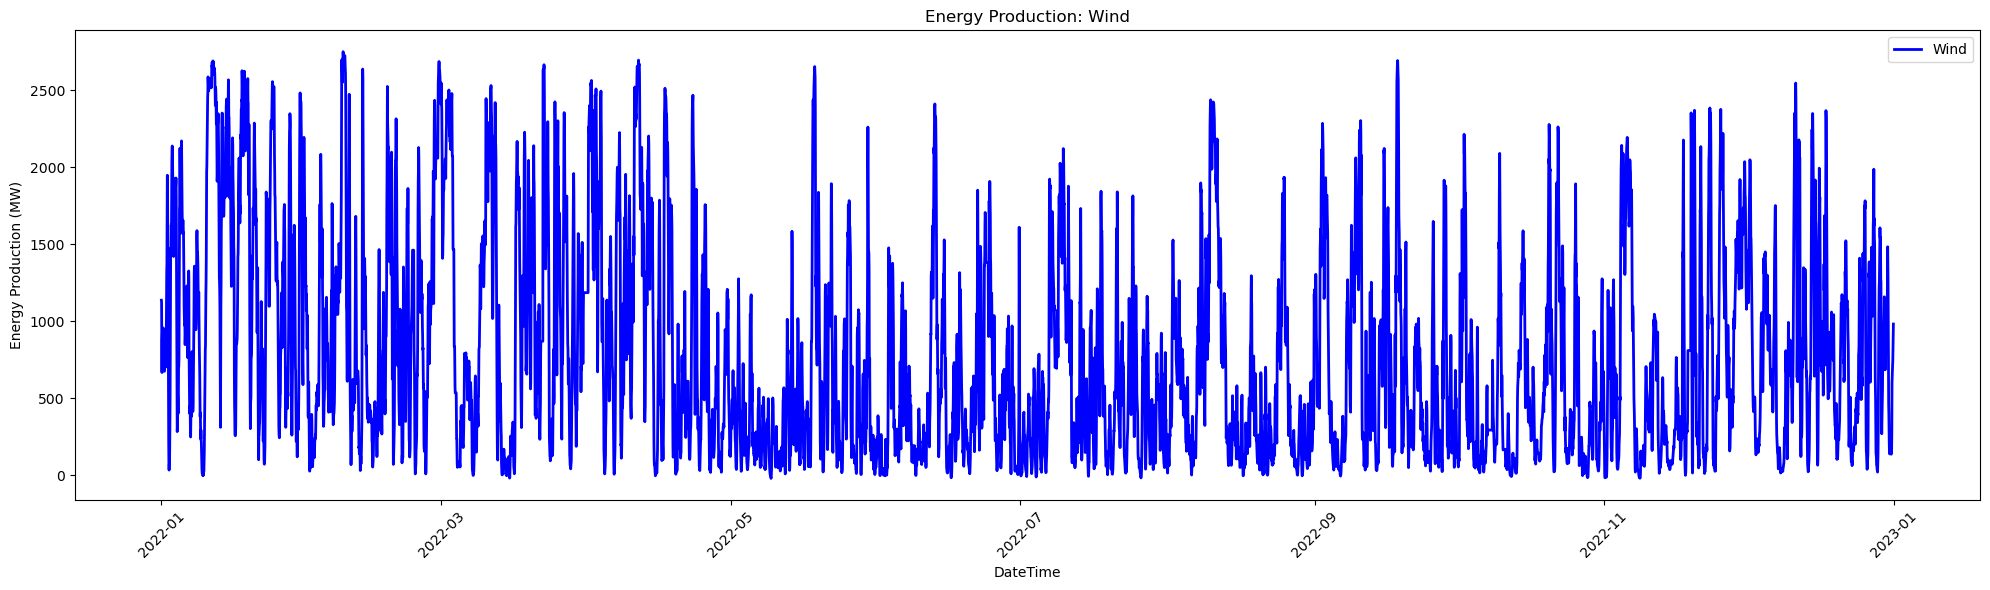

In [18]:
# Find intermittency of wind
plt.figure(figsize=(20, 6))

# Plot for Wind
plt.plot(data_2022.index, data_2022['Wind'], label='Wind', color='blue', linewidth=2)

# Add labels and title
plt.xlabel('DateTime')
plt.ylabel('Energy Production (MW)')
plt.title('Energy Production: Wind')
plt.legend(loc='upper right')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
plt.tight_layout()
# Save the plot
plt.savefig('example_plot3.png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()

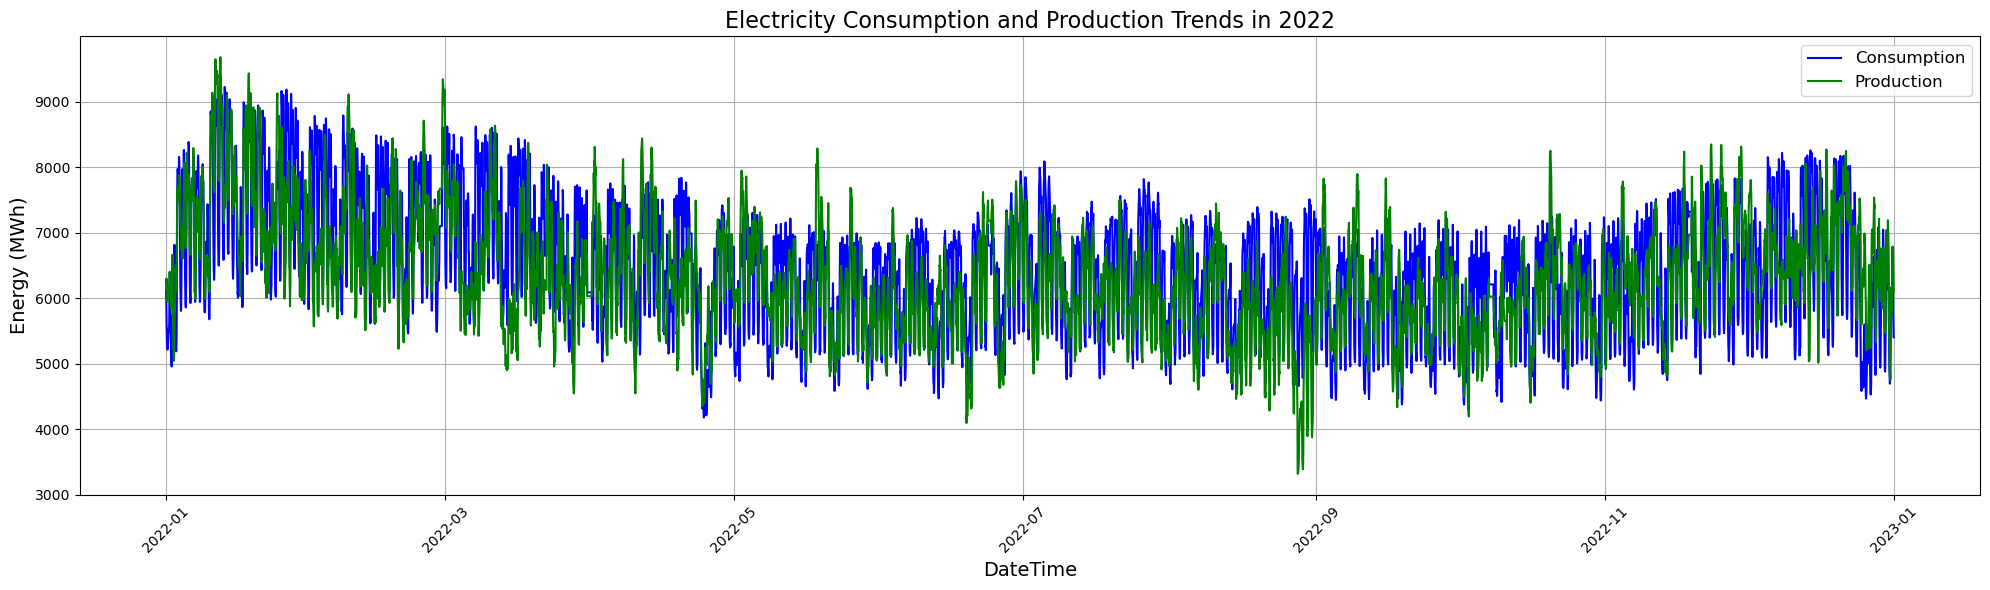

In [19]:
#Electricity Consumption and Production Trends in 2022
import matplotlib.pyplot as plt

# Plot data for 2022
plt.figure(figsize=(20, 6))

# Plot consumption
plt.plot(data_2022.index, data_2022['Consumption'], label='Consumption', color='blue', linewidth=1.5)

# Plot production
plt.plot(data_2022.index, data_2022['Production'], label='Production', color='green', linewidth=1.5)

# Add titles and labels
plt.title('Electricity Consumption and Production Trends in 2022', fontsize=16)
plt.xlabel('DateTime', fontsize=14)
plt.ylabel('Energy (MWh)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Improve x-axis for better readability
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
# Save the plot
plt.savefig('example_plot4.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

# Data preprocessing for clustering

In [22]:
# Features for clustering
c_data = data_2022[['Consumption']]
p_data=data_2022[['Production']]


In [23]:
c_data

,Consumption
2022-01-01 00:00:00,6120.0
2022-01-01 01:00:00,5923.0
2022-01-01 02:00:00,5630.0
2022-01-01 03:00:00,5408.0
2022-01-01 04:00:00,5296.0
...,...
2022-12-31 19:00:00,6557.0
2022-12-31 20:00:00,6335.0
2022-12-31 21:00:00,5728.0
2022-12-31 22:00:00,5564.0


In [24]:
# Reshaped consumption data for clustering
c_data['date'] = c_data.index.date  # Extract the date part
c_data['hour'] = c_data.index.hour  # Extract the hour part

# Pivot the DataFrame to have hours (0-23) as columns and dates as rows
c_reshaped_data = c_data.pivot(index='date', columns='hour')

# Flatten the column MultiIndex (optional)
c_reshaped_data.columns = [f"{col[1]}" for col in c_reshaped_data.columns]

# Reset the index if needed
c_reshaped_data.reset_index(inplace=True)

# Check the result
print(c_reshaped_data)

           date       0       1       2       3       4       5       6  \
0    2022-01-01  6120.0  5923.0  5630.0  5408.0  5296.0  5252.0  5222.0   
1    2022-01-02  5338.0  5133.0  5038.0  4973.0  4955.0  5056.0  5159.0   
2    2022-01-03  5497.0  5296.0  5216.0  5187.0  5277.0  5454.0  5952.0   
3    2022-01-04  6165.0  6045.0  5876.0  5804.0  5847.0  6040.0  6543.0   
4    2022-01-05  6289.0  6064.0  5919.0  5867.0  5856.0  6088.0  6379.0   
..          ...     ...     ...     ...     ...     ...     ...     ...   
360  2022-12-27  4862.0  4640.0  4551.0  4526.0  4587.0  4665.0  4982.0   
361  2022-12-28  5144.0  4977.0  4894.0  4826.0  4886.0  5004.0  5426.0   
362  2022-12-29  5268.0  5125.0  5011.0  4938.0  5007.0  5129.0  5447.0   
363  2022-12-30  5309.0  5086.0  4968.0  4882.0  4877.0  5078.0  5292.0   
364  2022-12-31  5232.0  4980.0  4830.0  4742.0  4692.0  4757.0  5005.0   

          7       8  ...      14      15      16      17      18      19  \
0    5213.0  5225.0  ..

C:\Users\mdabu\AppData\Local\Temp\ipykernel_3932\2350019097.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_data['date'] = c_data.index.date  # Extract the date part
C:\Users\mdabu\AppData\Local\Temp\ipykernel_3932\2350019097.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_data['hour'] = c_data.index.hour  # Extract the hour part


In [26]:
s_data = c_reshaped_data.drop(columns=['date'])

In [27]:
s_data

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,6120.0,5923.0,5630.0,5408.0,5296.0,5252.0,5222.0,5213.0,5225.0,5286.0,...,5481.0,5514.0,5670.0,6251.0,6392.0,6358.0,6319.0,6142.0,5861.0,5566.0
1,5338.0,5133.0,5038.0,4973.0,4955.0,5056.0,5159.0,5329.0,5507.0,5716.0,...,5759.0,5916.0,6163.0,6663.0,6813.0,6769.0,6698.0,6529.0,6108.0,5731.0
2,5497.0,5296.0,5216.0,5187.0,5277.0,5454.0,5952.0,6785.0,7393.0,7853.0,...,7722.0,7663.0,7739.0,8155.0,8144.0,7991.0,7869.0,7512.0,7028.0,6483.0
3,6165.0,6045.0,5876.0,5804.0,5847.0,6040.0,6543.0,7264.0,7797.0,7965.0,...,7642.0,7587.0,7678.0,8187.0,8261.0,8081.0,8057.0,7673.0,7144.0,6650.0
4,6289.0,6064.0,5919.0,5867.0,5856.0,6088.0,6379.0,7290.0,7894.0,7955.0,...,7611.0,7568.0,7637.0,8145.0,8383.0,8316.0,8150.0,7776.0,7208.0,6727.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,4862.0,4640.0,4551.0,4526.0,4587.0,4665.0,4982.0,5487.0,5891.0,6157.0,...,5867.0,5941.0,6132.0,6615.0,6639.0,6525.0,6404.0,6191.0,5767.0,5393.0
361,5144.0,4977.0,4894.0,4826.0,4886.0,5004.0,5426.0,5897.0,6387.0,6722.0,...,6295.0,6346.0,6606.0,6989.0,7080.0,6979.0,6813.0,6570.0,5983.0,5566.0
362,5268.0,5125.0,5011.0,4938.0,5007.0,5129.0,5447.0,5909.0,6365.0,6567.0,...,6260.0,6302.0,6538.0,7001.0,7045.0,6905.0,6739.0,6414.0,6003.0,5596.0
363,5309.0,5086.0,4968.0,4882.0,4877.0,5078.0,5292.0,5647.0,6056.0,6338.0,...,6133.0,6226.0,6528.0,6939.0,6971.0,6880.0,6688.0,6367.0,5971.0,5536.0


In [28]:
# Production data preprocessing
p_data['date'] = p_data.index.date  # Extract the date part
p_data['hour'] = p_data.index.hour  # Extract the hour part

# Pivot the DataFrame to have hours (0-23) as columns and dates as rows
p_reshaped_data = p_data.pivot(index='date', columns='hour')

# Flatten the column MultiIndex (optional)
p_reshaped_data.columns = [f"{col[1]}" for col in p_reshaped_data.columns]

# Reset the index if needed
p_reshaped_data.reset_index(inplace=True)

# Check the result
print(p_reshaped_data)

           date       0       1       2       3       4       5       6  \
0    2022-01-01  6126.0  6276.0  6298.0  6199.0  6215.0  6156.0  5945.0   
1    2022-01-02  6136.0  5831.0  6020.0  6089.0  6257.0  6432.0  6431.0   
2    2022-01-03  6401.0  6506.0  6332.0  6097.0  6120.0  6197.0  6755.0   
3    2022-01-04  7177.0  7102.0  7075.0  6988.0  6901.0  6779.0  6729.0   
4    2022-01-05  7291.0  6901.0  6896.0  6991.0  6766.0  7091.0  7041.0   
..          ...     ...     ...     ...     ...     ...     ...     ...   
360  2022-12-27  5520.0  5239.0  5405.0  5486.0  5545.0  5585.0  5561.0   
361  2022-12-28  6545.0  6037.0  5852.0  5593.0  5438.0  5372.0  5323.0   
362  2022-12-29  6441.0  6009.0  6069.0  6109.0  5987.0  5958.0  6022.0   
363  2022-12-30  5832.0  5729.0  5568.0  5530.0  5490.0  5468.0  5586.0   
364  2022-12-31  5508.0  5330.0  5051.0  4936.0  4883.0  4868.0  4746.0   

          7       8  ...      14      15      16      17      18      19  \
0    6001.0  5983.0  ..

C:\Users\mdabu\AppData\Local\Temp\ipykernel_3932\1849137804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_data['date'] = p_data.index.date  # Extract the date part
C:\Users\mdabu\AppData\Local\Temp\ipykernel_3932\1849137804.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_data['hour'] = p_data.index.hour  # Extract the hour part


In [30]:
s2_data = p_reshaped_data.drop(columns=['date'])

In [31]:
s2_data

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,6126.0,6276.0,6298.0,6199.0,6215.0,6156.0,5945.0,6001.0,5983.0,5953.0,...,6051.0,6050.0,6022.0,6306.0,6399.0,6339.0,6294.0,6222.0,6101.0,6202.0
1,6136.0,5831.0,6020.0,6089.0,6257.0,6432.0,6431.0,6460.0,6661.0,6383.0,...,5049.0,5041.0,5080.0,5287.0,5560.0,5665.0,5737.0,5869.0,6229.0,6438.0
2,6401.0,6506.0,6332.0,6097.0,6120.0,6197.0,6755.0,7159.0,7465.0,7561.0,...,7586.0,7532.0,7608.0,7767.0,7876.0,7845.0,7804.0,7750.0,7742.0,7301.0
3,7177.0,7102.0,7075.0,6988.0,6901.0,6779.0,6729.0,7088.0,6955.0,6875.0,...,6773.0,6748.0,6874.0,7289.0,7588.0,7826.0,8032.0,8066.0,7916.0,7665.0
4,7291.0,6901.0,6896.0,6991.0,6766.0,7091.0,7041.0,7650.0,8211.0,8189.0,...,7639.0,7528.0,7481.0,7531.0,7880.0,7887.0,7723.0,7493.0,7358.0,6761.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,5520.0,5239.0,5405.0,5486.0,5545.0,5585.0,5561.0,6610.0,6952.0,7029.0,...,6679.0,6753.0,6928.0,7106.0,7299.0,7447.0,7536.0,7362.0,7426.0,6741.0
361,6545.0,6037.0,5852.0,5593.0,5438.0,5372.0,5323.0,6014.0,6331.0,6526.0,...,6177.0,6152.0,6190.0,6319.0,6598.0,6777.0,7020.0,7210.0,6942.0,6635.0
362,6441.0,6009.0,6069.0,6109.0,5987.0,5958.0,6022.0,6502.0,6756.0,6698.0,...,5917.0,5914.0,6023.0,6284.0,6717.0,6766.0,6620.0,6521.0,6384.0,5936.0
363,5832.0,5729.0,5568.0,5530.0,5490.0,5468.0,5586.0,6284.0,6495.0,6767.0,...,6221.0,6260.0,6591.0,6903.0,7187.0,7004.0,7009.0,6738.0,6318.0,5704.0


In [32]:
p_supply = s2_data.to_numpy()

In [33]:
p_supply

array([[6126., 6276., 6298., ..., 6222., 6101., 6202.],
       [6136., 5831., 6020., ..., 5869., 6229., 6438.],
       [6401., 6506., 6332., ..., 7750., 7742., 7301.],
       ...,
       [6441., 6009., 6069., ..., 6521., 6384., 5936.],
       [5832., 5729., 5568., ..., 6738., 6318., 5704.],
       [5508., 5330., 5051., ..., 6430., 6259., 6088.]])

In [37]:
supply = p_supply.flatten()
print(supply)

[6126. 6276. 6298. ... 6430. 6259. 6088.]


In [46]:
supply.size

8760

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [51]:
#  Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(s_data)


In [53]:
data_normalized 



array([[ 0.75494139,  0.76288619,  0.43155237, ..., -1.40094519,
        -1.210539  , -0.91516478],
       [-0.71731863, -0.71571057, -0.66629239, ..., -0.7456851 ,
        -0.74765837, -0.60181099],
       [-0.41797164, -0.41063301, -0.33619717, ...,  0.91870939,
         0.97643143,  0.82632267],
       ...,
       [-0.84910661, -0.7306837 , -0.71636301, ..., -0.94040063,
        -0.94442949, -0.85819136],
       [-0.7719165 , -0.80367772, -0.79610511, ..., -1.01998002,
        -1.00439783, -0.9721382 ],
       [-0.91688328, -1.00207172, -1.05202163, ..., -2.10192111,
        -1.76712016, -1.22851858]])

# Determine the best number of clusters using silhouette scores

In [56]:
# Determine the best number of clusters using silhouette scores
clusters_list = [6, 12, 24, 36]
silhouette_scores = []

for n_clusters in clusters_list:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data_normalized)
    silhouette_avg = silhouette_score(data_normalized, cluster_labels)
    silhouette_scores.append(silhouette_avg)

C:\Users\mdabu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\mdabu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\mdabu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\mdabu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

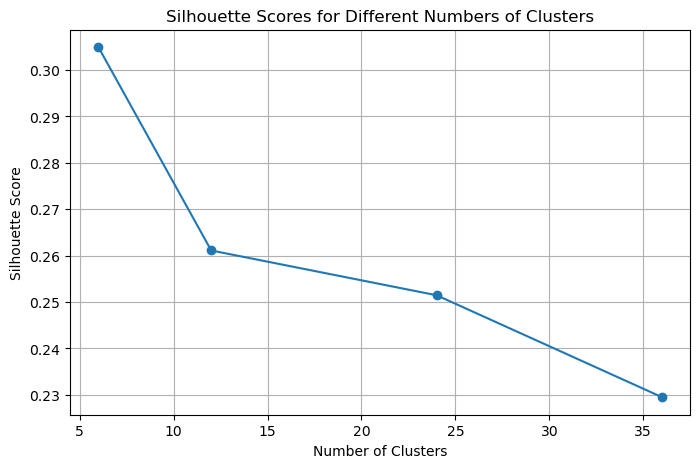

In [58]:
# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(clusters_list, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
# Save the plot
plt.savefig('example_plot5.png', dpi=300, bbox_inches='tight')
plt.show()

In [59]:
# Choose the optimal number of clusters (e.g., based on highest silhouette score)
optimal_clusters = clusters_list[np.argmax(silhouette_scores)]
print(f"Optimal Number of Clusters: {optimal_clusters}")

Optimal Number of Clusters: 6


# Perform clustering with the optimal number of clusters

C:\Users\mdabu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\mdabu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


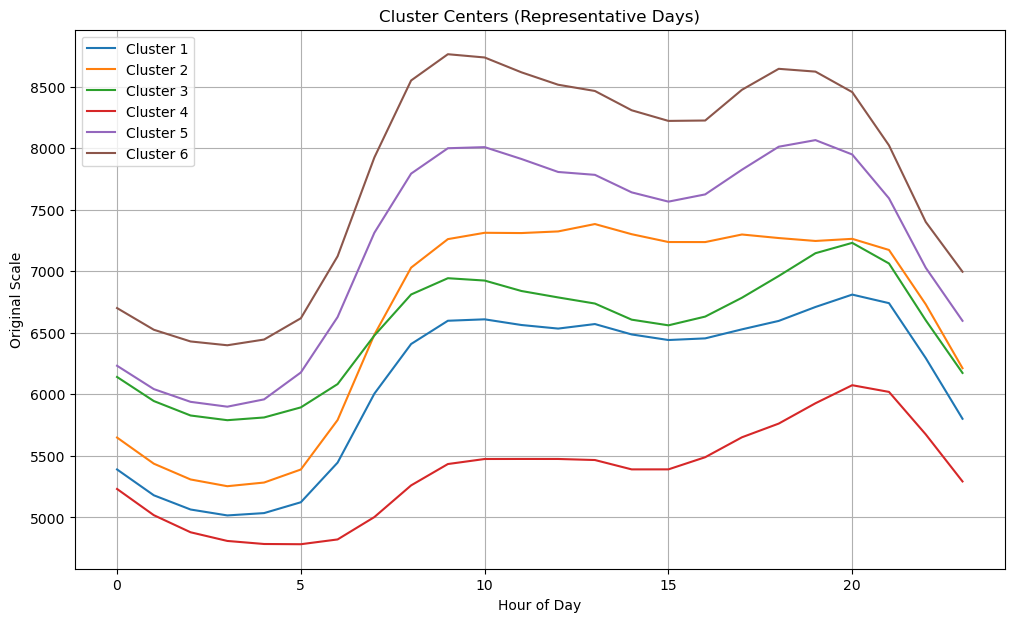

In [63]:
# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
s_data['Cluster'] = kmeans.fit_predict(data_normalized)
clusters = kmeans.fit_predict(data_normalized)
#  Find representative days (Cluster Centers)
cluster_centers = kmeans.cluster_centers_  # Shape: (optimal_clusters, 6)

# Convert cluster centers back to the original scale for interpretation
cluster_centers_original_scale = scaler.inverse_transform(cluster_centers)
# Plot the cluster centers (Representative Days)
plt.figure(figsize=(12, 7))
for i, center in enumerate(cluster_centers_original_scale):
    plt.plot(range(24), center, label=f'Cluster {i+1}')
plt.title('Cluster Centers (Representative Days)')
plt.xlabel('Hour of Day')
plt.ylabel('Original Scale')
plt.legend()
plt.grid(True)
# Save the plot
plt.savefig('example_plot6.png', dpi=300, bbox_inches='tight')
plt.show()

In [64]:
cluster_centers_original_scale

array([[5389.79527559, 5179.96062992, 5064.41732283, 5016.34645669,
        5035.32283465, 5123.43307087, 5445.34645669, 6005.26771654,
        6408.81889764, 6597.62992126, 6609.21259843, 6563.1023622 ,
        6534.04724409, 6570.80314961, 6486.39370079, 6441.12598425,
        6454.46456693, 6527.80314961, 6596.30708661, 6709.53543307,
        6810.09448819, 6740.59055118, 6294.46456693, 5801.47244094],
       [5648.92307692, 5436.70769231, 5308.50769231, 5253.70769231,
        5283.47692308, 5389.33846154, 5791.35384615, 6484.41538462,
        7029.15384615, 7260.63076923, 7312.13846154, 7309.96923077,
        7323.24615385, 7383.07692308, 7300.63076923, 7237.09230769,
        7236.69230769, 7298.24615385, 7269.44615385, 7245.75384615,
        7263.01538462, 7172.61538462, 6731.13846154, 6212.30769231],
       [6140.97727273, 5945.5       , 5828.04545455, 5789.90909091,
        5812.09090909, 5894.        , 6083.20454545, 6477.72727273,
        6811.06818182, 6943.18181818, 6924.113

In [65]:
clusters


array([3, 0, 1, 4, 4, 4, 4, 4, 2, 5, 5, 5, 5, 5, 4, 2, 5, 5, 5, 5, 5, 4,
       2, 4, 5, 5, 5, 5, 4, 2, 4, 5, 5, 5, 5, 4, 2, 4, 5, 5, 4, 4, 2, 2,
       4, 4, 4, 4, 4, 2, 0, 4, 4, 5, 4, 4, 2, 2, 5, 5, 4, 4, 5, 4, 2, 4,
       4, 5, 5, 5, 4, 2, 4, 4, 4, 4, 4, 2, 2, 4, 4, 2, 2, 2, 2, 3, 1, 2,
       2, 2, 2, 0, 3, 1, 2, 2, 1, 2, 0, 0, 1, 2, 2, 2, 2, 0, 0, 1, 4, 4,
       2, 2, 3, 3, 3, 0, 0, 1, 0, 0, 3, 0, 1, 2, 2, 2, 0, 3, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 1, 1, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 0, 1, 1, 1, 2, 0,
       3, 1, 1, 1, 1, 1, 2, 0, 1, 4, 1, 1, 1, 0, 3, 0, 0, 0, 1, 1, 0, 3,
       0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 3, 0, 0, 0, 1, 1, 0, 3, 1,
       1, 0, 0, 0, 3, 3, 3, 0, 0, 1, 1, 0, 3, 0, 1, 1, 1, 1, 0, 3, 1, 1,
       1, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0,
       0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 2, 3, 0, 2, 0, 0,
       0, 3, 3, 0, 2, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0,

# Clustered representative days with new chronological order

In [70]:
representative_days =s_data['Cluster']
num_days = len(representative_days) # Assuming representative_days has one row per day
representative_days = pd.DataFrame({
    'Day': np.arange(1, num_days+1),
    'Cluster': clusters
})

In [72]:
representative_days

,Day,Cluster
0,1,3
1,2,0
2,3,1
3,4,4
4,5,4
...,...,...
360,361,3
361,362,0
362,363,0
363,364,0


In [74]:
# Let's assume each timeslice corresponds to a 6-hour period (for simplicity)
timeslice_length = 6  # hours
num_timeslices_per_day = 24 // timeslice_length  # Number of timeslices in a day

In [77]:
# Create a sequential array of timeperiods for all days
timeperiods = np.arange(1, num_days * num_timeslices_per_day + 1)
timeperiods

array([   1,    2,    3, ..., 1458, 1459, 1460])

In [79]:
# Map representative days to timeperiods
timeperiod_mapping = {}
for day in range(1, num_days + 1):
    cluster = representative_days.loc[representative_days['Day'] == day, 'Cluster'].values[0]
    start_index = (day - 1) * num_timeslices_per_day
    for timeslice in range(num_timeslices_per_day):
        timeperiod_mapping[start_index + timeslice + 1] = {
            'Day': day,
            'Cluster': cluster,
            'Timeslice': timeslice + 1
        }


timeperiod_df = pd.DataFrame(timeperiod_mapping)

In [81]:
timeperiod_df

,1,2,3,4,5,6,7,8,9,10,...,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460
Day,1,1,1,1,2,2,2,2,3,3,...,363,363,364,364,364,364,365,365,365,365
Cluster,3,3,3,3,0,0,0,0,1,1,...,0,0,0,0,0,0,3,3,3,3
Timeslice,1,2,3,4,1,2,3,4,1,2,...,3,4,1,2,3,4,1,2,3,4


In [82]:
# Display first 10 timeperiod mappings
for tp in list(timeperiod_mapping.keys())[:10]:
    print(f"Timeperiod {tp}: {timeperiod_mapping[tp]}")

Timeperiod 1: {'Day': 1, 'Cluster': 3, 'Timeslice': 1}
Timeperiod 2: {'Day': 1, 'Cluster': 3, 'Timeslice': 2}
Timeperiod 3: {'Day': 1, 'Cluster': 3, 'Timeslice': 3}
Timeperiod 4: {'Day': 1, 'Cluster': 3, 'Timeslice': 4}
Timeperiod 5: {'Day': 2, 'Cluster': 0, 'Timeslice': 1}
Timeperiod 6: {'Day': 2, 'Cluster': 0, 'Timeslice': 2}
Timeperiod 7: {'Day': 2, 'Cluster': 0, 'Timeslice': 3}
Timeperiod 8: {'Day': 2, 'Cluster': 0, 'Timeslice': 4}
Timeperiod 9: {'Day': 3, 'Cluster': 1, 'Timeslice': 1}
Timeperiod 10: {'Day': 3, 'Cluster': 1, 'Timeslice': 2}


In [83]:
supply = representative_days.values.flatten()


In [87]:
all_clusters = s_data['Cluster']
print(all_clusters)

0      3
1      0
2      1
3      4
4      4
      ..
360    3
361    0
362    0
363    0
364    3
Name: Cluster, Length: 365, dtype: int32


In [89]:
all_representative_clusters = representative_days['Cluster']
print(all_representative_clusters)

0      3
1      0
2      1
3      4
4      4
      ..
360    3
361    0
362    0
363    0
364    3
Name: Cluster, Length: 365, dtype: int32


In [91]:
all_timeperiod_clusters = timeperiod_df
print(all_timeperiod_clusters)

           1     2     3     4     5     6     7     8     9     10    ...  \
Day           1     1     1     1     2     2     2     2     3     3  ...   
Cluster       3     3     3     3     0     0     0     0     1     1  ...   
Timeslice     1     2     3     4     1     2     3     4     1     2  ...   

           1451  1452  1453  1454  1455  1456  1457  1458  1459  1460  
Day         363   363   364   364   364   364   365   365   365   365  
Cluster       0     0     0     0     0     0     3     3     3     3  
Timeslice     3     4     1     2     3     4     1     2     3     4  

[3 rows x 1460 columns]


In [93]:
all_clusters_list = s_data['Cluster'].tolist()
print(all_clusters_list)

[3, 0, 1, 4, 4, 4, 4, 4, 2, 5, 5, 5, 5, 5, 4, 2, 5, 5, 5, 5, 5, 4, 2, 4, 5, 5, 5, 5, 4, 2, 4, 5, 5, 5, 5, 4, 2, 4, 5, 5, 4, 4, 2, 2, 4, 4, 4, 4, 4, 2, 0, 4, 4, 5, 4, 4, 2, 2, 5, 5, 4, 4, 5, 4, 2, 4, 4, 5, 5, 5, 4, 2, 4, 4, 4, 4, 4, 2, 2, 4, 4, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 0, 3, 1, 2, 2, 1, 2, 0, 0, 1, 2, 2, 2, 2, 0, 0, 1, 4, 4, 2, 2, 3, 3, 3, 0, 0, 1, 0, 0, 3, 0, 1, 2, 2, 2, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 1, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 0, 1, 1, 1, 2, 0, 3, 1, 1, 1, 1, 1, 2, 0, 1, 4, 1, 1, 1, 0, 3, 0, 0, 0, 1, 1, 0, 3, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 3, 0, 0, 0, 1, 1, 0, 3, 1, 1, 0, 0, 0, 3, 3, 3, 0, 0, 1, 1, 0, 3, 0, 1, 1, 1, 1, 0, 3, 1, 1, 1, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 2, 3, 0, 2, 0, 0, 0, 3, 3, 0, 2, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 1, 1, 1, 0, 3, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 0, 1, 1, 

In [95]:
# Replace cluster indices with centroid values
c_demand = np.array([cluster_centers_original_scale[cluster] for cluster in all_clusters_list])

# `centroids_replaced` is now the array with centroid values corresponding to each data point
print(c_demand)

[[5231.2745098  5018.43137255 4879.50980392 ... 6019.70588235
  5674.7254902  5292.43137255]
 [5389.79527559 5179.96062992 5064.41732283 ... 6740.59055118
  6294.46456693 5801.47244094]
 [5648.92307692 5436.70769231 5308.50769231 ... 7172.61538462
  6731.13846154 6212.30769231]
 ...
 [5389.79527559 5179.96062992 5064.41732283 ... 6740.59055118
  6294.46456693 5801.47244094]
 [5389.79527559 5179.96062992 5064.41732283 ... 6740.59055118
  6294.46456693 5801.47244094]
 [5231.2745098  5018.43137255 4879.50980392 ... 6019.70588235
  5674.7254902  5292.43137255]]


In [97]:
demand = c_demand.flatten()
print(demand)

[5231.2745098  5018.43137255 4879.50980392 ... 6019.70588235 5674.7254902
 5292.43137255]


In [99]:
supply = p_supply.flatten()

In [101]:
demand.size


8760

In [103]:
supply.size

8760

In [105]:
total_supply = np.sum(supply)
print(total_supply)

55204163.0


In [107]:
total_demand = np.sum(demand)
print(total_demand)

56292449.0


In [109]:
# Parameters
time_steps = 365  # Total number of time steps (e.g., days)

initial_soc = 0  # Initial State of Charge (SOC)
min_soc =0  # Minimum SOC
max_soc = 5000  # Maximum SOC (upper limit for testing)


In [111]:
def charge_discharge(supply, demand, prev_soc, battery_capacity, charge_rate, discharge_rate, 
                     charging_efficiency, discharging_efficiency, min_soc, max_soc):
    net_energy = supply - demand
    if net_energy > 0:  # Surplus energy, charge the battery
        effective_charge = min(net_energy * charging_efficiency, charge_rate)
        soc = min(prev_soc + effective_charge, max_soc)
    else:  # Deficit, discharge the battery
        effective_discharge = min(abs(net_energy) / discharging_efficiency, discharge_rate)
        soc = max(prev_soc - effective_discharge, min_soc)
    return soc

In [113]:
# System Optimization (Experiment with different configurations)
battery_capacity_options = [2000, 2500, 3000]  # MW (2000 MW, 2500 MW, 3000 MWh\)
charging_rates = [0.8 * 1000, 1.0 * 1000, 1.2 * 1000]  # Charge rates as multiples of base rate
discharging_rates = [0.8 * 1000, 1.0 * 1000, 1.2 * 1000]  # Discharge rates as multiples of base rate

best_soc = None
best_unmet_demand = float('inf')
best_config = None

# Loop through different configurations
for capacity in battery_capacity_options:
    for charge_rate in charging_rates:
        for discharge_rate in discharging_rates:
            # Recalculate SOC with the new configuration
            soc = np.zeros(time_steps)
            soc[0] = initial_soc
            
            for t in range(1, time_steps):
                soc[t] = charge_discharge(
                    supply[t], 
                    demand[t], 
                    soc[t-1], 
                    capacity, 
                    charge_rate, 
                    discharge_rate, 
                    0.95,  # Charging efficiency
                    0.90,  # Discharging efficiency
                    min_soc, 
                    capacity  # Max SOC = capacity
                )
            
            # Calculate unmet demand
            unmet_demand = np.maximum(demand - supply, 0)
            total_unmet_demand = np.sum(unmet_demand)
            
            # Store the best configuration
            if total_unmet_demand < best_unmet_demand:
                best_unmet_demand = total_unmet_demand
                best_soc = soc
                best_config = (capacity, charge_rate, discharge_rate)

In [115]:
# Output the best configuration and total unmet demand
print(f"Best Configuration: Capacity = {best_config[0]} MW, "
      f"Charge Rate = {best_config[1]} MWh/day, "
      f"Discharge Rate = {best_config[2]} MWh/day")
print(f"Total Unmet Demand: {best_unmet_demand:.2f} MWh")


Best Configuration: Capacity = 2000 MW, Charge Rate = 800.0 MWh/day, Discharge Rate = 800.0 MWh/day
Total Unmet Demand: 3203008.19 MWh


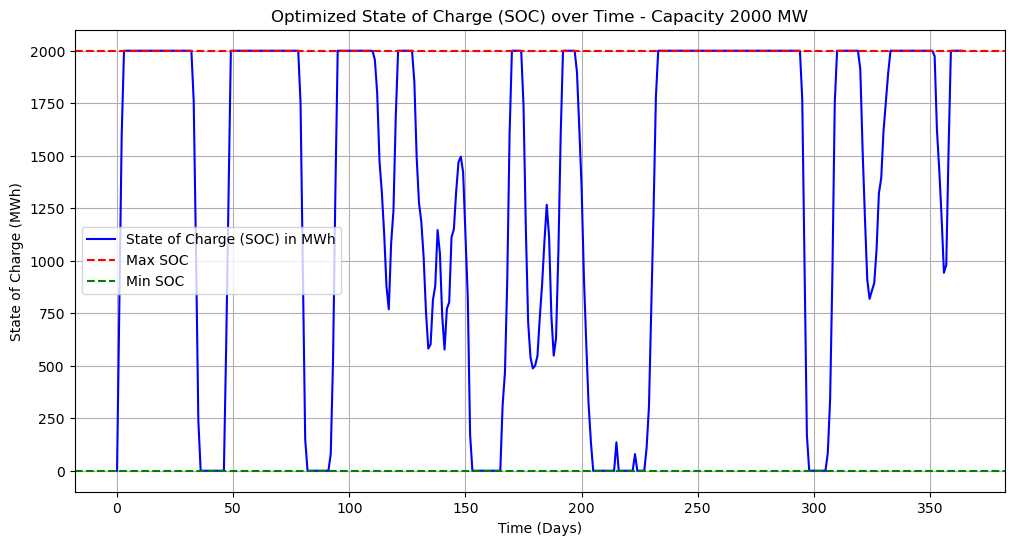

In [117]:
# Plot the best SOC curve based on the optimized configuration
plt.figure(figsize=(12, 6))
plt.plot(best_soc, label="State of Charge (SOC) in MWh", color='b')
plt.axhline(best_config[0], color='r', linestyle='--', label="Max SOC")
plt.axhline(min_soc, color='g', linestyle='--', label="Min SOC")
plt.title(f'Optimized State of Charge (SOC) over Time - Capacity {best_config[0]} MW')
plt.xlabel('Time (Days)')
plt.ylabel('State of Charge (MWh)')
plt.legend()
plt.grid(True)
# Save the plot
plt.savefig('example_plot7.png', dpi=300, bbox_inches='tight')
plt.show()

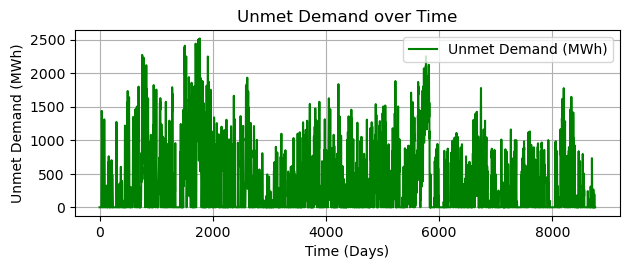

In [119]:
plt.subplot(2, 1, 2)
plt.plot(unmet_demand, label="Unmet Demand (MWh)", color='g')
plt.title('Unmet Demand over Time')
plt.xlabel('Time (Days)')
plt.ylabel('Unmet Demand (MWh)')
plt.legend()
plt.grid(True)

plt.tight_layout()
# Save the plot
plt.savefig('example_plot8.png', dpi=300, bbox_inches='tight')
plt.show()

# Optimal cluster 6¶
# Best Configuration: Capacity = 2000 MW, Charge Rate = 800.0 MWh/day, Discharge Rate = 800.0 MWh/day
# Total Unmet Demand: 3203008.19 MWh